In [50]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
import pingouin as pg
import datetime
import pytz
import pandas as pd
import datetime

In [52]:
ds04 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0004-D.nc')
ds05 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0005-C.nc')
ds06 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0006-D.nc')
ds07 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0007-C.nc')
ds08 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0008-C.nc')
ds09 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0009-C.nc')
ds10 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0010-C.nc')
ds11 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0011-C.nc')
ds12 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0012-C.nc')
ds13 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0013-C.nc')
ds14 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0014-C.nc')
ds15 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0015-C.nc')
ds16 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0016-C.nc')
ds17 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0017-C.nc')
ds18 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0018-C.nc')
ds19 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0019-C.nc')

dsall = [ds04, ds05, ds06, ds07, ds08, ds09, ds10, ds11, ds12, ds13, ds14,
         ds15, ds16, ds17, ds18, ds19]


df_out_buoy = pd.read_csv("data/wind_data/bouy_46011_wind - Sheet1.csv", header=None)
df_out_buoy.rename(columns={0: 'yr',1: 'mo',2: 'dy',3: 'hr', 4: 'mn', 5: 'degT', 6: 'wndsd'}, inplace=True)

df_in_buoy = pd.read_csv("data/wind_data/Cal_poly_wind - Sheet1.csv", header=None)
df_in_buoy.rename(columns={0: 'yr',1: 'mo',2: 'dy',3: 'hr', 4: 'mn', 5: 'degT', 6: 'wndsd'}, inplace=True)

df_out_buoy['datetime_utc'] = pd.to_datetime({'year': df_out_buoy['yr'],'month': df_out_buoy['mo'],
                            'day': df_out_buoy['dy'],'hour': df_out_buoy['hr'],'minute': df_out_buoy['mn']}, utc=True)

df_in_buoy['datetime_utc'] = pd.to_datetime({'year': df_in_buoy['yr'],'month': df_in_buoy['mo'],
                            'day': df_in_buoy['dy'],'hour': df_in_buoy['hr'],'minute': df_in_buoy['mn']}, utc=True)

# Convert to Los Angeles local time (Pacific Time, handles DST)
df_out_buoy['datetime_local'] = df_out_buoy['datetime_utc'].dt.tz_convert('America/Los_Angeles')
df_in_buoy['datetime_local'] = df_in_buoy['datetime_utc'].dt.tz_convert('America/Los_Angeles')

In [27]:
myfuncs.slo_map()

NameError: name 'myfuncs' is not defined

In [54]:
Wind_threshold = 6
bay_threshold = -120.725
max_pressure = 10

diss_strong_in, press_strong_in, time_strong_in, wind_strong_in, lat_strong_in, long_strong_in, N2_strong_in= [], [], [], [], [], [], []
diss_strong_out, press_strong_out, time_strong_out, wind_strong_out, lat_strong_out, long_strong_out, N2_strong_out = [], [], [], [], [], [], []
diss_weak_in, press_weak_in, time_weak_in, wind_weak_in, lat_weak_in, long_weak_in, N2_weak_in = [], [], [], [], [], [], []
diss_weak_out, press_weak_out, time_weak_out, wind_weak_out, lat_weak_out, long_weak_out, N2_weak_out = [], [], [], [], [], [], []


# Loop over all datasets
for ds in dsall:
    num_profiles = len(ds['dissipation'].values)
    for i in range(num_profiles):
    # Loop over each profile in the dissipation data (across profiles)    
        long_i = ds['profile_long'].values[i, 0]
        lat_i = ds['profile_lat'].values[i, 0]
        diss_i = ds['dissipation'].values[i, :]
        press_i = ds['pressure'].values[i,:] 
        N2_i = ds['N_squared'].values[i, :]
        
        epoch_time = ds['start_time'].values[i, 0]
        
        if 0 < ds['wind'].values[i,0] < 100:    
            wind_i = ds['wind'].values[i, 0]
        else:
            print(f"Skipping bad wind value: {wind_i} at index {i}")
            continue  # Skip to the next profile

        # Only proceed if the timestamp is within a reasonable UNIX time range
        if 1e8 < epoch_time < 2e9:  # Approx. years 1973–2033
            utc_time = pd.to_datetime(epoch_time, unit='s', utc=True)
            local_time = utc_time.tz_convert('America/Los_Angeles')
            time_i = local_time
        else:
            print(f"Skipping bad timestamp: {epoch_time} at index {i}")
            continue  # Skip to the next profile

        mask = press_i < max_pressure
        diss_i = diss_i[mask]
        press_i = press_i[mask] 
        N2_i = N2_i[mask]


        if wind_i >= Wind_threshold and long_i >= bay_threshold:
            diss_strong_in.append(diss_i.tolist()) 
            press_strong_in.append(press_i.tolist())
            N2_strong_in.append(N2_i.tolist())
            time_strong_in.append(time_i)
            wind_strong_in.append(wind_i)
            lat_strong_in.append(lat_i)
            long_strong_in.append(long_i)
        elif wind_i >= Wind_threshold and long_i < bay_threshold:
            diss_strong_out.append(diss_i.tolist())
            press_strong_out.append(press_i.tolist())
            N2_strong_out.append(N2_i.tolist())
            time_strong_out.append(time_i)
            wind_strong_out.append(wind_i)
            lat_strong_out.append(lat_i)
            long_strong_out.append(long_i)
        elif wind_i < Wind_threshold and long_i >= bay_threshold:
            diss_weak_in.append(diss_i.tolist())
            press_weak_in.append(press_i.tolist())
            N2_weak_in.append(N2_i.tolist())
            time_weak_in.append(time_i)
            wind_weak_in.append(wind_i)
            lat_weak_in.append(lat_i)
            long_weak_in.append(long_i)
        elif wind_i < Wind_threshold and long_i < bay_threshold:
            diss_weak_out.append(diss_i.tolist())
            press_weak_out.append(press_i.tolist())
            N2_weak_out.append(N2_i.tolist())
            time_weak_out.append(time_i)
            wind_weak_out.append(wind_i)
            lat_weak_out.append(lat_i)
            long_weak_out.append(long_i)
           
df_strong_in = pd.DataFrame({'time': time_strong_in,'wind': wind_strong_in, 'N_squared': N2_strong_in,
    'dissipation': diss_strong_in,'pressure': press_strong_in, 'latitude': lat_strong_in, 'longitude': long_strong_in})

df_strong_out = pd.DataFrame({'time': time_strong_out,'wind': wind_strong_out, 'N_squared': N2_strong_out,
    'dissipation': diss_strong_out,'pressure': press_strong_out, 'latitude': lat_strong_out, 'longitude': long_strong_out})

df_weak_in = pd.DataFrame({'time': time_weak_in,'wind': wind_weak_in, 'N_squared': N2_weak_in,
    'dissipation': diss_weak_in,'pressure': press_weak_in, 'latitude': lat_weak_in, 'longitude': long_weak_in})

df_weak_out = pd.DataFrame({'time': time_weak_out,'wind': wind_weak_out, 'N_squared': N2_weak_out,
    'dissipation': diss_weak_out,'pressure': press_weak_out, 'latitude': lat_weak_out, 'longitude': long_weak_out}) 

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

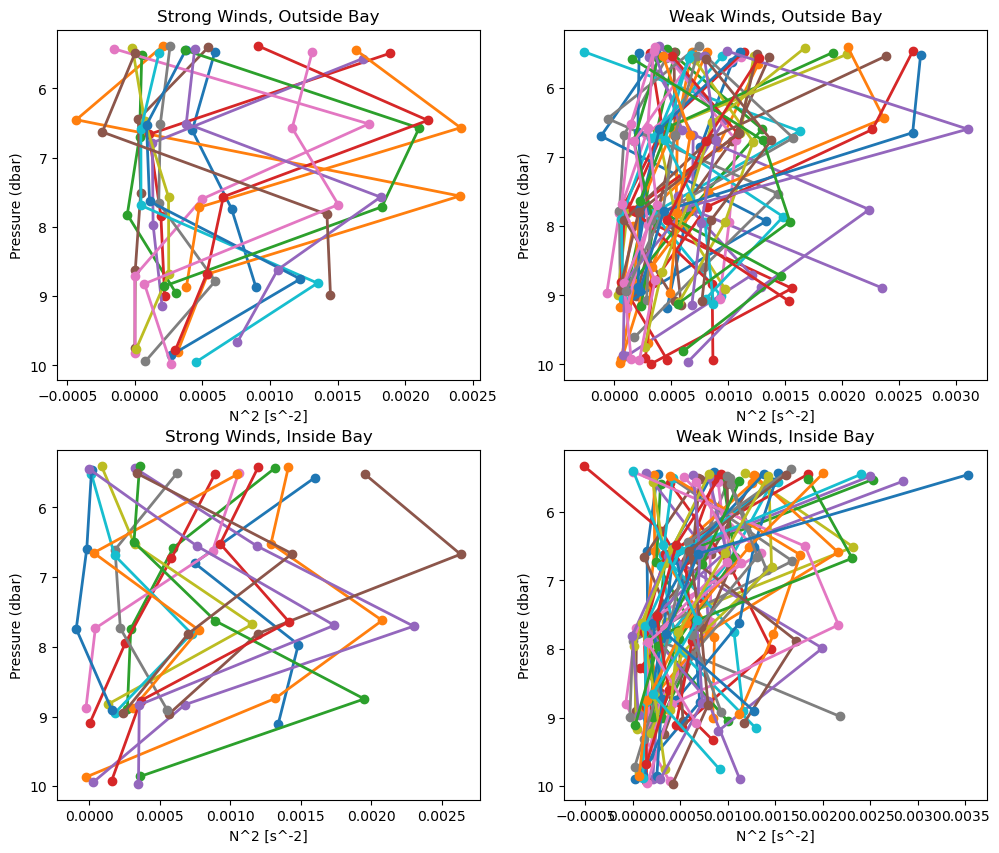

In [56]:
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
for i in range(len(df_strong_out['N_squared'])):
    plt.plot((df_strong_out['N_squared'][i]), df_strong_out['pressure'][i], linewidth=2, marker='o')
    
plt.gca().invert_yaxis() 
plt.title('Strong Winds, Outside Bay')
plt.xlabel('N^2 [s^-2]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,2)
for i in range(len(df_weak_out['N_squared'])):
    plt.plot((df_weak_out['N_squared'][i]), df_weak_out['pressure'][i], linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Weak Winds, Outside Bay')
plt.xlabel('N^2 [s^-2]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,3)
for i in range(len(df_strong_in['N_squared'])):
    plt.plot((df_strong_in['N_squared'][i]), df_strong_in['pressure'][i], linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Strong Winds, Inside Bay')
plt.xlabel('N^2 [s^-2]')
plt.ylabel('Pressure (dbar)')


plt.subplot(2,2,4)
for i in range(len(df_weak_in['N_squared'])):
    plt.plot((df_weak_in['N_squared'][i]), df_weak_in['pressure'][i], linewidth=2, marker='o')  
plt.gca().invert_yaxis() 
plt.title('Weak Winds, Inside Bay')
plt.xlabel('N^2 [s^-2]')
plt.ylabel('Pressure (dbar)')

plt.tight_layout

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1262258505.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1262258505.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1262258505.py:25: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1262258505.py:34: Syntax

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

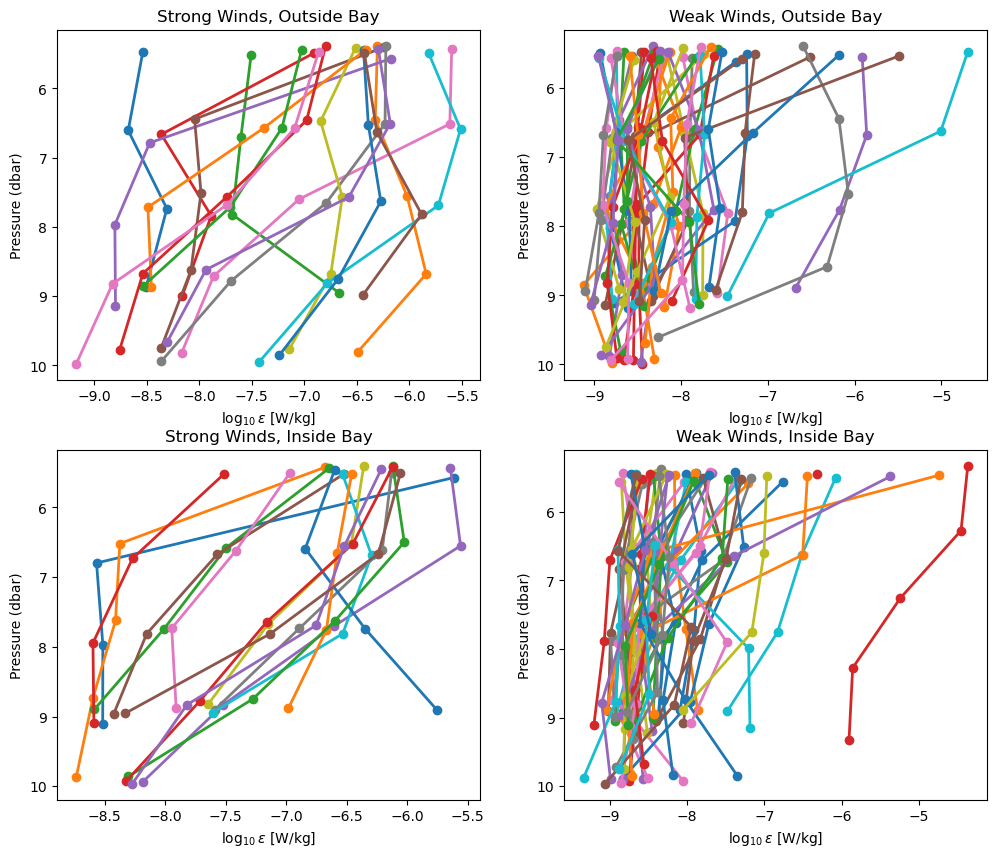

In [58]:
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
for i in range(len(df_strong_out['dissipation'])):
    plt.plot(np.log10(df_strong_out['dissipation'][i]), df_strong_out['pressure'][i], linewidth=2, marker='o')
    
plt.gca().invert_yaxis() 
plt.title('Strong Winds, Outside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,2)
for i in range(len(df_weak_out['dissipation'])):
    plt.plot(np.log10(df_weak_out['dissipation'][i]), df_weak_out['pressure'][i], linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Weak Winds, Outside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,3)
for i in range(len(df_strong_in['dissipation'])):
    plt.plot(np.log10(df_strong_in['dissipation'][i]), df_strong_in['pressure'][i], linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Strong Winds, Inside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')


plt.subplot(2,2,4)
for i in range(len(df_weak_in['dissipation'])):
    plt.plot(np.log10(df_weak_in['dissipation'][i]), df_weak_in['pressure'][i], linewidth=2, marker='o')  
plt.gca().invert_yaxis() 
plt.title('Weak Winds, Inside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.tight_layout

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:48: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:48: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/911285176.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/911285176.py:31: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/911285176.py:39: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/911285176.py:48: SyntaxW

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

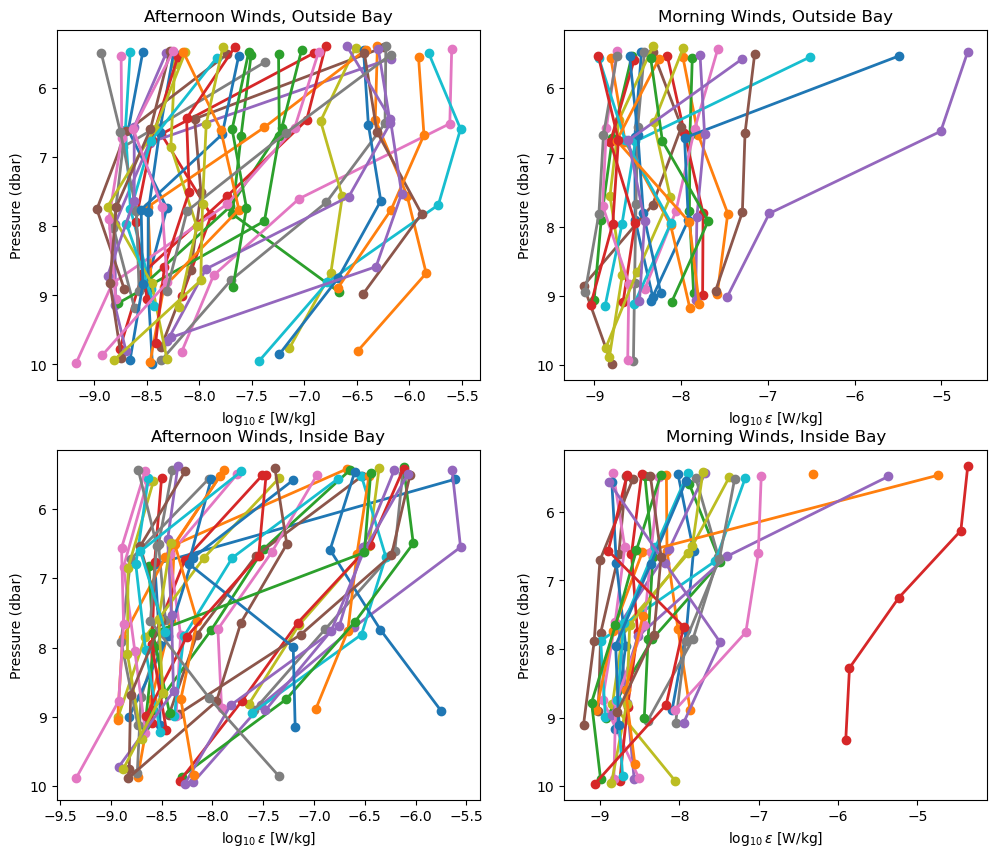

In [60]:
plt.figure(figsize=(12, 10))
frames_in = [df_strong_in, df_weak_in]
frames_out = [df_strong_out, df_weak_out]
df_in = pd.concat(frames_in)
df_out = pd.concat(frames_out)

idx_morning_out = df_out['time'].dt.hour < 12
idx_afternoon_out = df_out['time'].dt.hour >= 12
idx_morning_in = df_in['time'].dt.hour < 12
idx_afternoon_in = df_in['time'].dt.hour >= 12

df_in_morning = df_in[idx_morning_in]
df_out_morning = df_out[idx_morning_out]
df_in_afternoon = df_in[idx_afternoon_in]
df_out_afternoon = df_out[idx_afternoon_out]

plt.subplot(2,2,1)
for i in range(len(df_out_afternoon['dissipation'])):
    plt.plot(np.log10(np.array(df_out_afternoon['dissipation'].iloc[i])), np.array(df_out_afternoon['pressure'].iloc[i]), linewidth=2, marker='o')
    
plt.gca().invert_yaxis() 
plt.title('Afternoon Winds, Outside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,2)
for i in range(len(df_out_morning['dissipation'])):
    plt.plot(np.log10(np.array(df_out_morning['dissipation'].iloc[i])), np.array(df_out_morning['pressure'].iloc[i]), linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Morning Winds, Outside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.subplot(2,2,3)
for i in range(len(df_in_afternoon['dissipation'])):
    plt.plot(np.log10(np.array(df_in_afternoon['dissipation'].iloc[i])), np.array(df_in_afternoon['pressure'].iloc[i]), linewidth=2, marker='o')    
plt.gca().invert_yaxis() 
plt.title('Afternoon Winds, Inside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')


plt.subplot(2,2,4)
for i in range(len(df_in_morning['dissipation'])):
    plt.plot(np.log10(np.array(df_in_morning['dissipation'].iloc[i])), np.array(df_in_morning['pressure'].iloc[i]), linewidth=2, marker='o')  
plt.gca().invert_yaxis() 
plt.title('Morning Winds, Inside Bay')
plt.xlabel('$\log_{10}\epsilon$ [W/kg]')
plt.ylabel('Pressure (dbar)')

plt.tight_layout

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/2324079123.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')


Text(0, 0.5, 'avg. $\\log_{10}\\epsilon$ [W/kg]')

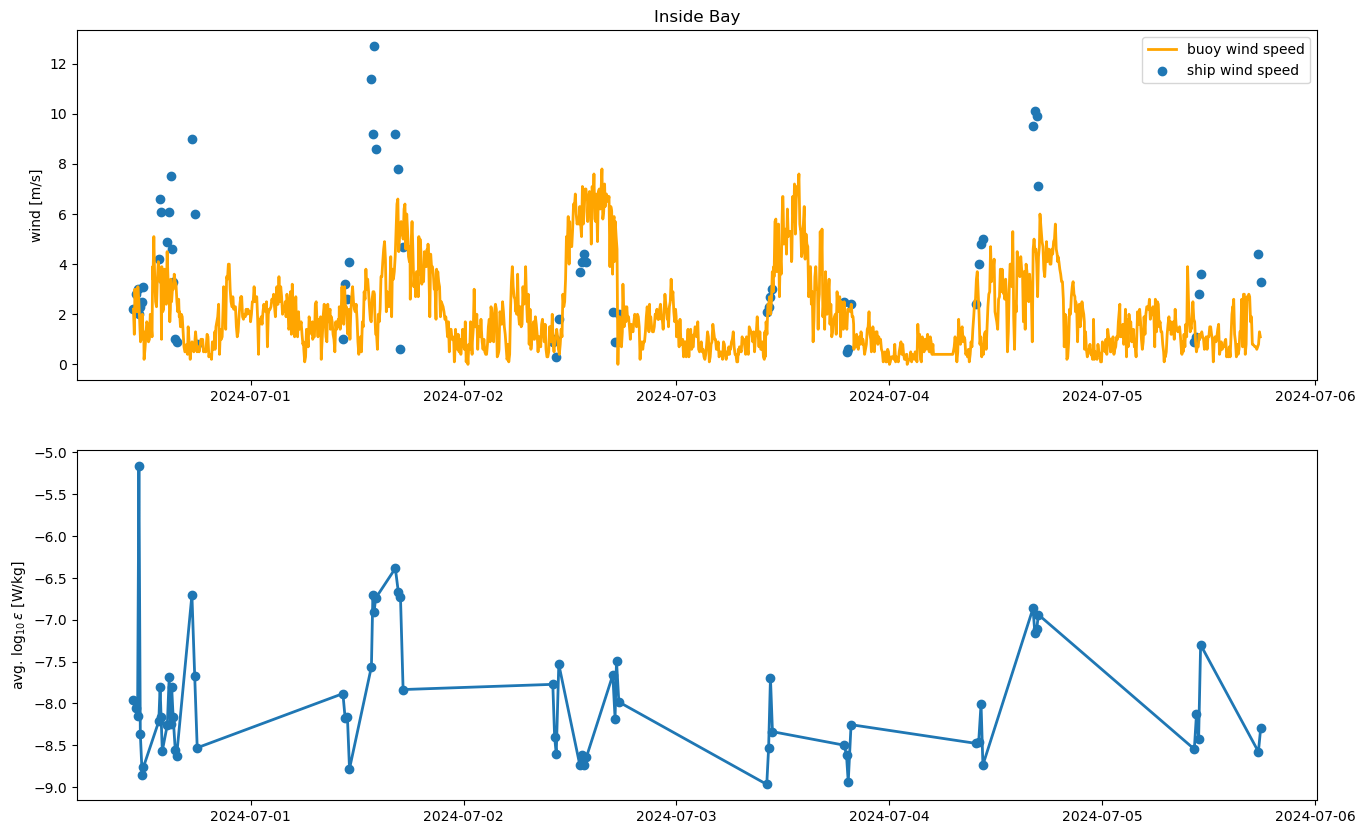

In [62]:
in_buoy_index = (df_in_buoy['datetime_local'] >= df_in['time'].min()) & (df_in_buoy['datetime_local'] <= df_in['time'].max())
#log_diss_mean_each = [np.nanmean(np.log10(d)) for d in df_in['dissipation']]

plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(df_in_buoy['datetime_local'][in_buoy_index], df_in_buoy['wndsd'][in_buoy_index], linewidth=2, color = 'orange', label = 'buoy wind speed')
plt.scatter( df_in['time'], df_in['wind'], label = 'ship wind speed')
plt.ylabel('wind [m/s]')
plt.legend()
plt.title('Inside Bay')


plt.subplot(2,1,2)
df_in_sorted = df_in.sort_values('time').reset_index(drop=True)
log_diss_mean_each = [np.nanmean(np.log10(d)) for d in df_in_sorted['dissipation']]
plt.plot(df_in_sorted['time'], log_diss_mean_each, linewidth=2, marker='o')   
plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')

(67,)

NumPy correlation coefficient: 0.5145701133229327


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/2264433480.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('avg. $\log_{10}\epsilon$ [W/kg]')


Text(0.5, 1.0, 'Inside Bay Wind speed vs Dissipation')

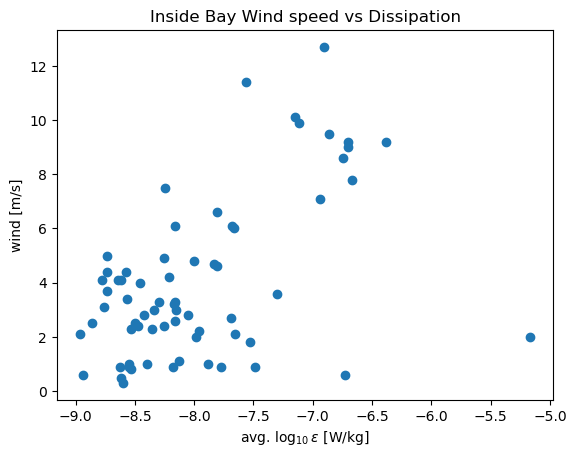

In [64]:
print(np.shape(df_in_sorted['wind']))
plt.figure()
#plt.scatter(df_all['wind'], mean_N2)
plt.scatter(log_diss_mean_each, df_in_sorted['wind'])
correlation_coefficient = np.corrcoef(log_diss_mean_each, df_in_sorted['wind'])[0, 1]
print("\nNumPy correlation coefficient:", correlation_coefficient)
plt.xlabel('avg. $\log_{10}\epsilon$ [W/kg]')
plt.ylabel('wind [m/s]')
plt.title('Inside Bay Wind speed vs Dissipation')


<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/2300161370.py:20: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')


Text(0, 0.5, 'avg. $\\log_{10}\\epsilon$ [W/kg]')

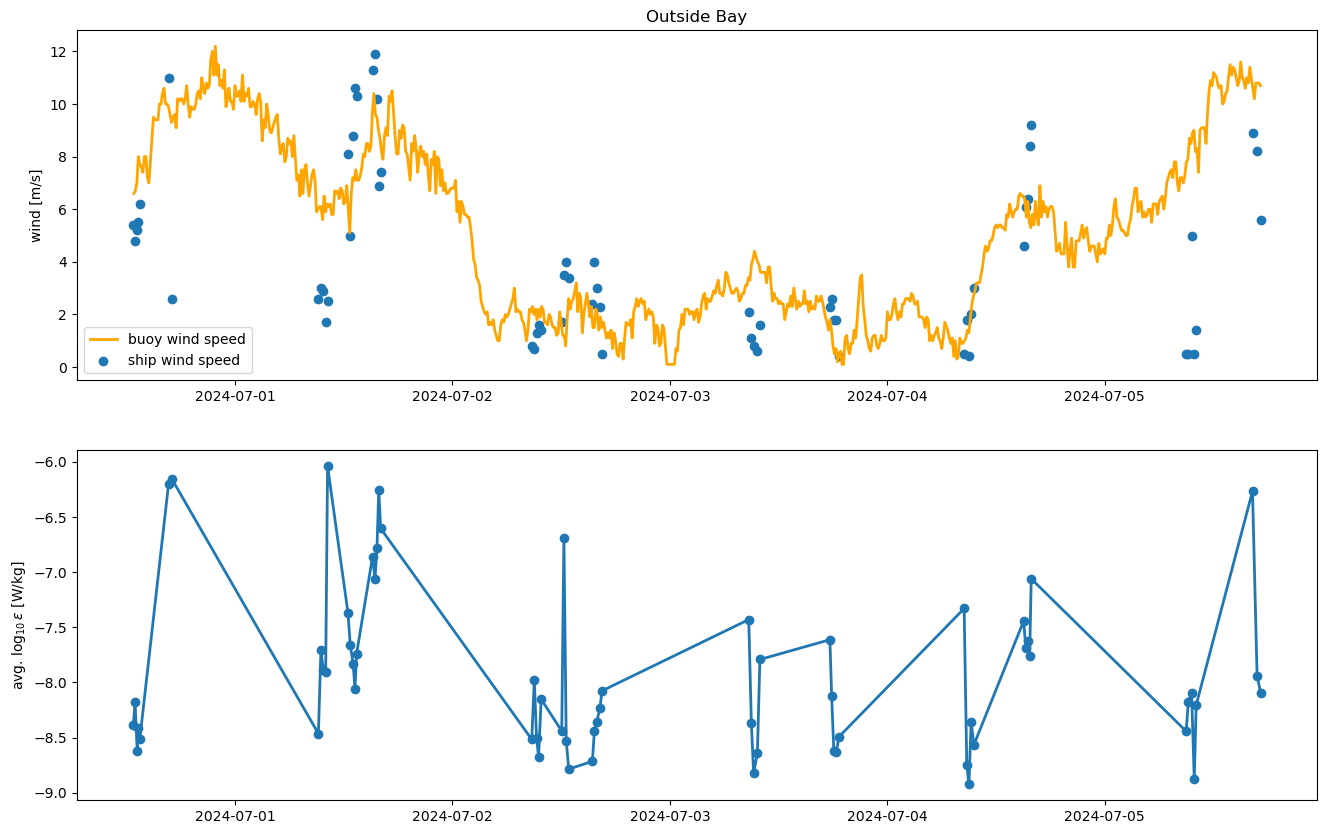

In [66]:
out_buoy_index = (
    (df_out_buoy['datetime_local'] >= df_out['time'].min()) &
    (df_out_buoy['datetime_local'] <= df_out['time'].max()) &
    (df_out_buoy['wndsd'] < 40)
)
#log_diss_mean_each = [np.nanmean(np.log10(d)) for d in df_in['dissipation']]
wind_thresh = df_out_buoy['wndsd'] < 40
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(df_out_buoy['datetime_local'][out_buoy_index], df_out_buoy['wndsd'][out_buoy_index], linewidth=2, color = 'orange', label = 'buoy wind speed')
plt.scatter( df_out['time'], df_out['wind'], label = 'ship wind speed')
plt.ylabel('wind [m/s]')
plt.legend()
plt.title('Outside Bay')

plt.subplot(2,1,2)
df_out_sorted = df_out.sort_values('time').reset_index(drop=True)
log_diss_mean_each = [np.nanmean(np.log10(d)) for d in df_out_sorted['dissipation']]
plt.plot(df_out_sorted['time'], log_diss_mean_each, linewidth=2, marker='o')   
plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/596197760.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')


Text(0, 0.5, 'avg. $\\log_{10}\\epsilon$ [W/kg]')

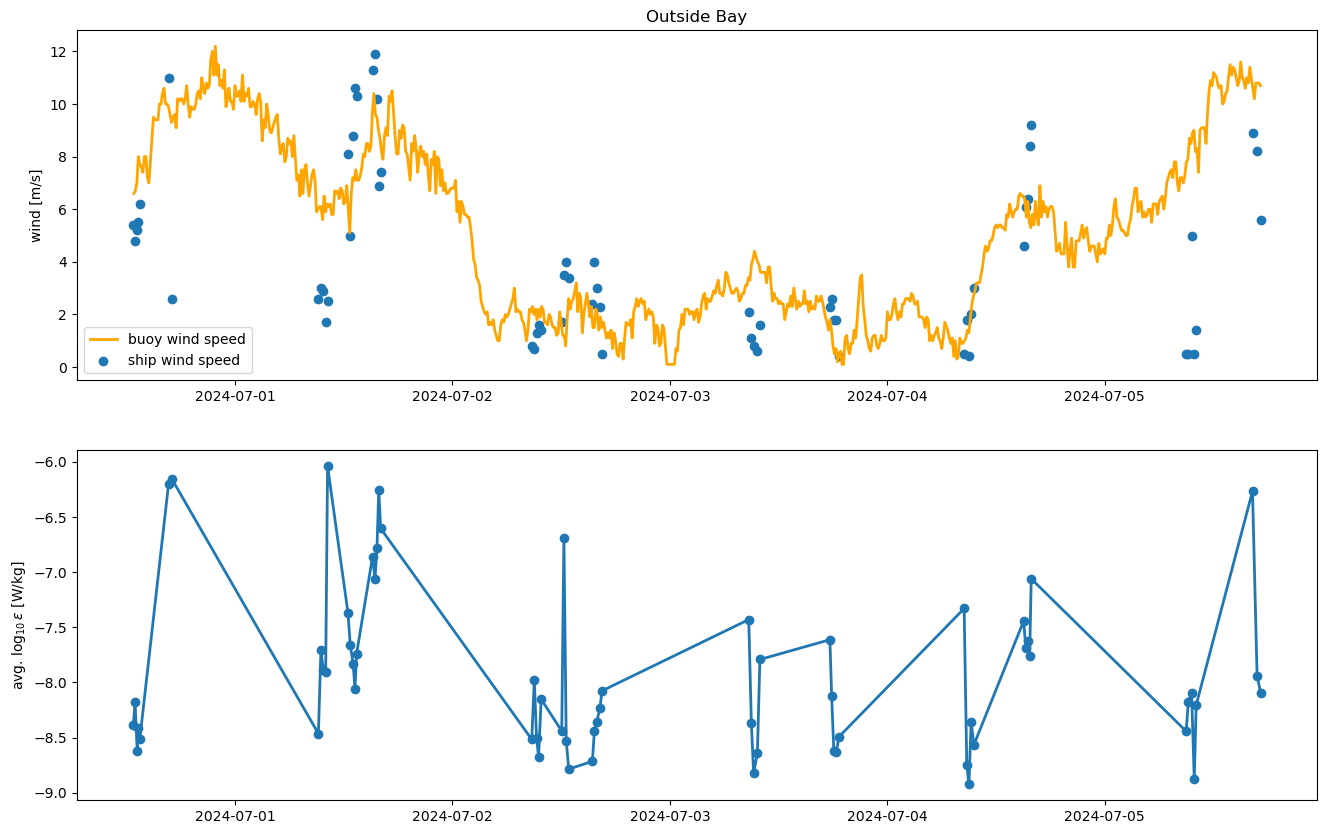

In [68]:
out_buoy_index = ((df_out_buoy['datetime_local'] >= df_out['time'].min()) &(df_out_buoy['datetime_local'] <= df_out['time'].max()) &
(df_out_buoy['wndsd'] < 30))

plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(df_out_buoy['datetime_local'][out_buoy_index], df_out_buoy['wndsd'][out_buoy_index], linewidth=2, color = 'orange', label = 'buoy wind speed')
plt.scatter( df_out['time'], df_out['wind'], label = 'ship wind speed')
plt.ylabel('wind [m/s]')
plt.legend()
plt.title('Outside Bay')


plt.subplot(2,1,2)
df_out_sorted = df_out.sort_values('time').reset_index(drop=True)
log_diss_mean_each = [np.nanmean(np.log10(d)) for d in df_out_sorted['dissipation']]
plt.plot(df_out_sorted['time'], log_diss_mean_each, linewidth=2, marker='o')   
plt.ylabel('avg. $\log_{10}\epsilon$ [W/kg]')

In [72]:
mean_weak_in = []
mean_weak_out = []
mean_strong_in = []
mean_strong_out = []


for profile in df_weak_in['dissipation']:
    mean_weak_in.append(np.array(np.nanmean(np.log10(profile))))
for profile in df_strong_in['dissipation']:
    mean_strong_in.append(np.array(np.nanmean(np.log10(profile))))
for profile in df_weak_out['dissipation']:
    mean_weak_out.append(np.array(np.nanmean(np.log10(profile))))   
for profile in df_strong_out['dissipation']:
    mean_strong_out.append(np.array(np.nanmean(np.log10(profile))))    

mean_weak_in = np.array(mean_weak_in)
mean_weak_in = mean_weak_in[~np.isnan(mean_weak_in)]

mean_weak_out = np.array(mean_weak_out)
mean_weak_out = mean_weak_out[~np.isnan(mean_weak_out)]

mean_strong_in = np.array(mean_strong_in)
mean_strong_in = mean_strong_in[~np.isnan(mean_strong_in)]

mean_strong_out = np.array(mean_strong_out)
mean_strong_out = mean_strong_out[~np.isnan(mean_strong_out)]

# Grand mean
list_of_means = [mean_weak_in, mean_weak_out, mean_strong_in, mean_strong_out]
all_means = np.concatenate(list_of_means)
grand_mean = np.nanmean(all_means)    
print(grand_mean)
N = len(all_means)
k = len(list_of_means)  # Number of groups

# Mean of each group
mean_weak_in_MSB = np.nanmean(mean_weak_in)
mean_weak_out_MSB = np.nanmean(mean_weak_out)
mean_strong_in_MSB = np.nanmean(mean_strong_in)
mean_strong_out_MSB = np.nanmean(mean_strong_out)

# Mean Square Between (MSB)
MSB = (
    len(mean_weak_in) * (mean_weak_in_MSB - grand_mean)**2 +
    len(mean_weak_out) * (mean_weak_out_MSB - grand_mean)**2 +
    len(mean_strong_in) * (mean_strong_in_MSB - grand_mean)**2 +
    len(mean_strong_out) * (mean_strong_out_MSB - grand_mean)**2
) / (k - 1) 

# Sum of Squares Within (SSW)
SSW = (
    np.nansum((mean_weak_in - mean_weak_in_MSB)**2) +
    np.nansum((mean_weak_out - mean_weak_out_MSB)**2) +
    np.nansum((mean_strong_in - mean_strong_in_MSB)**2) +
    np.nansum((mean_strong_out - mean_strong_out_MSB)**2)
)


# Mean Square Within
MSW = SSW / (N - k)

# F-statistic
F_stat = MSB / MSW

print("F-statistic:", F_stat)
from scipy.stats import f_oneway

F_scipy, pval = f_oneway(mean_weak_in, mean_weak_out, mean_strong_in, mean_strong_out)
print("F-statistic (scipy):", F_scipy)
print("p-value:", pval)
print(stats.tukey_hsd(mean_weak_in, mean_weak_out, mean_strong_in, mean_strong_out))

-7.945542716084441
F-statistic: 18.46934185981128
F-statistic (scipy): 18.46934185981127
p-value: 5.253225789929509e-10
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.055     0.973    -0.387     0.278
 (0 - 2)     -1.004     0.000    -1.475    -0.533
 (0 - 3)     -0.939     0.000    -1.400    -0.479
 (1 - 0)      0.055     0.973    -0.278     0.387
 (1 - 2)     -0.949     0.000    -1.425    -0.473
 (1 - 3)     -0.884     0.000    -1.350    -0.419
 (2 - 0)      1.004     0.000     0.533     1.475
 (2 - 1)      0.949     0.000     0.473     1.425
 (2 - 3)      0.065     0.991    -0.508     0.638
 (3 - 0)      0.939     0.000     0.479     1.400
 (3 - 1)      0.884     0.000     0.419     1.350
 (3 - 2)     -0.065     0.991    -0.638     0.508



In [74]:
mean_in_morning = []
mean_out_morning = []
mean_in_afternoon = []
mean_out_afternoon = []


for profile in df_in_morning['dissipation']:
    mean_in_morning.append(np.array(np.nanmean(np.log10(profile))))
for profile in df_out_morning['dissipation']:
    mean_out_morning.append(np.array(np.nanmean(np.log10(profile))))
for profile in df_in_afternoon['dissipation']:
    mean_in_afternoon.append(np.array(np.nanmean(np.log10(profile))))   
for profile in df_out_afternoon['dissipation']:
    mean_out_afternoon.append(np.array(np.nanmean(np.log10(profile))))    

mean_in_morning = np.array(mean_in_morning)
mean_in_morning = mean_in_morning [~np.isnan(mean_in_morning)]

mean_out_morning = np.array(mean_out_morning)
mean_out_morning = mean_out_morning[~np.isnan(mean_out_morning)]

mean_in_afternoon = np.array(mean_in_afternoon)
mean_in_afternoon = mean_in_afternoon[~np.isnan(mean_in_afternoon)]

mean_out_afternoon = np.array(mean_out_afternoon)
mean_out_afternoon = mean_out_afternoon[~np.isnan(mean_out_afternoon)]

F_scipy, pval = f_oneway(mean_in_morning, mean_out_morning, mean_in_afternoon, mean_out_afternoon)
print("F-statistic (scipy):", F_scipy)
print("p-value:", pval)
print(stats.tukey_hsd(mean_in_morning, mean_out_morning, mean_in_afternoon, mean_out_afternoon))

F-statistic (scipy): 2.7848556418589974
p-value: 0.04354008685506092
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.028     0.999    -0.502     0.558
 (0 - 2)     -0.311     0.326    -0.787     0.164
 (0 - 3)     -0.405     0.128    -0.883     0.073
 (1 - 0)     -0.028     0.999    -0.558     0.502
 (1 - 2)     -0.339     0.272    -0.826     0.148
 (1 - 3)     -0.433     0.103    -0.922     0.057
 (2 - 0)      0.311     0.326    -0.164     0.787
 (2 - 1)      0.339     0.272    -0.148     0.826
 (2 - 3)     -0.094     0.942    -0.523     0.336
 (3 - 0)      0.405     0.128    -0.073     0.883
 (3 - 1)      0.433     0.103    -0.057     0.922
 (3 - 2)      0.094     0.942    -0.336     0.523



In [78]:
mean_strong_in_N2 = []
mean_strong_out_N2 = []
mean_weak_in_N2 = []
mean_weak_out_N2 = []


for profile in df_weak_in['N_squared']:
    mean_weak_in_N2.append(np.array(np.nanmean(profile)))
for profile in df_weak_out['N_squared']:
    mean_weak_out_N2.append(np.array(np.nanmean(profile)))
for profile in df_strong_out['N_squared']:
    mean_strong_out_N2.append(np.array(np.nanmean(profile)))  
for profile in df_strong_in['N_squared']:
    mean_strong_in_N2.append(np.array(np.nanmean(profile)))   

mean_weak_in_N2 = np.array(mean_weak_in_N2)
mean_weak_in_N2 = mean_weak_in_N2[~np.isnan(mean_weak_in_N2)]

mean_weak_out_N2 = np.array(mean_weak_out_N2)
mean_weak_out_N2 = mean_weak_out_N2[~np.isnan(mean_weak_out_N2)]

mean_strong_in_N2 = np.array(mean_strong_in_N2)
mean_strong_in_N2 = mean_strong_in_N2[~np.isnan(mean_strong_in_N2)]

mean_strong_out_N2 = np.array(mean_strong_out_N2)
mean_strong_out_N2 = mean_strong_out_N2[~np.isnan(mean_strong_out_N2)]

F_scipy, pval = f_oneway(mean_weak_in_N2, mean_weak_out_N2, mean_strong_in_N2, mean_strong_out_N2)
print("F-statistic (scipy):", F_scipy)
print("p-value:", pval)
print(stats.tukey_hsd(mean_weak_in_N2, mean_weak_out_N2, mean_strong_in_N2, mean_strong_out_N2))

F-statistic (scipy): 0.6819894964833279
p-value: 0.5646359466511885
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.000     0.939    -0.000     0.000
 (0 - 2)      0.000     0.999    -0.000     0.000
 (0 - 3)      0.000     0.499    -0.000     0.000
 (1 - 0)     -0.000     0.939    -0.000     0.000
 (1 - 2)     -0.000     0.993    -0.000     0.000
 (1 - 3)      0.000     0.763    -0.000     0.000
 (2 - 0)     -0.000     0.999    -0.000     0.000
 (2 - 1)      0.000     0.993    -0.000     0.000
 (2 - 3)      0.000     0.739    -0.000     0.000
 (3 - 0)     -0.000     0.499    -0.000     0.000
 (3 - 1)     -0.000     0.763    -0.000     0.000
 (3 - 2)     -0.000     0.739    -0.000     0.000



<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/3300293718.py:38: SyntaxWarning: invalid escape sequence '\e'
  cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')


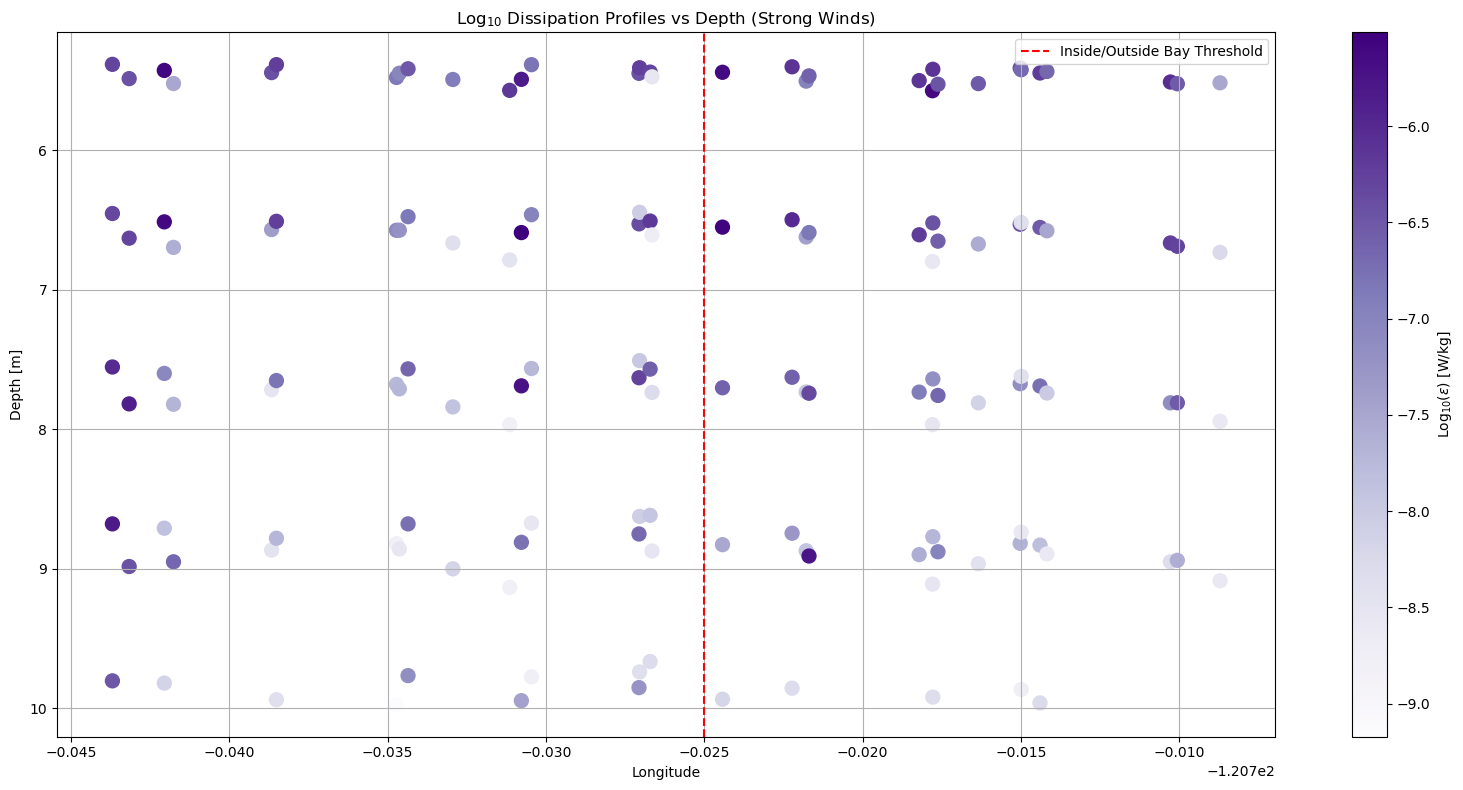

In [81]:
# Combine all data
df_strong = pd.concat([df_strong_in, df_strong_out])
df_strong_sorted = df_strong.sort_values('longitude').reset_index(drop=True)

# Flatten profile data into individual points
longitudes = []
depths = []
log_dissipation = []

for i, row in df_strong_sorted.iterrows():
    diss = np.array(row['dissipation'])
    depth = np.array(row['pressure'])
    lon = row['longitude']
    
    # Filter out mismatched or missing values
    if len(diss) != len(depth) or np.isnan(lon):
        continue
    
    log_eps = np.log10(diss)
    
    # Remove nan or inf
    mask = np.isfinite(log_eps) & np.isfinite(depth)
    
    longitudes.extend([lon] * np.sum(mask))
    depths.extend(depth[mask])
    log_dissipation.extend(log_eps[mask])

# Create scatter plot
plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c=log_dissipation, cmap='Purples', s=100)
plt.gca().invert_yaxis()  # Depth increases downward
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Log$_{10}$ Dissipation Profiles vs Depth (Strong Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')
plt.grid(True)
plt.tight_layout()

<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1380482194.py:37: SyntaxWarning: invalid escape sequence '\e'
  cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')


,time,wind,N_squared,dissipation,pressure,latitude,longitude
0,2024-07-02 08:45:15-07:00,0.8,"[0.0006796238146488348, 0.0005549246625470732,...","[4.735911446605868e-09, 1.0065849651843547e-08...","[5.476998447893927, 6.555484022369587, 7.68326...",35.119137,-120.744893
1,2024-07-03 08:42:00-07:00,2.1,"[0.002390160771708304, 0.000858123982192152, 8...","[3.259349533407568e-06, 1.0926055254337621e-08...","[5.5300416532464, 6.716055657839692, 7.9031159...",35.119432,-120.744306
2,2024-07-05 08:58:30-07:00,0.5,"[0.00042718768463971665, 0.0006691176034473563...","[2.537637420276957e-09, 3.1651129867917e-09, 3...","[5.527037691439016, 6.671949644430164, 7.80672...",35.119105,-120.743346
3,2024-06-30 12:47:15-07:00,5.4,"[0.0010377629656509455, 0.0007574769092038101,...","[4.2286012745265025e-08, 1.8757442317546945e-0...","[5.619509340917005, 6.851920680620901, 8.02183...",35.118610,-120.743274
4,2024-07-04 15:02:00-07:00,4.6,"[0.0026910895317503554, 0.002621117375938554, ...","[6.644983011531366e-07, 6.724618785103844e-08,...","[5.512943344453201, 6.642961097741843, 7.77804...",35.118939,-120.742928
...,...,...,...,...,...,...,...
93,2024-06-30 15:16:30-07:00,3.3,"[0.0012562066883452696, 0.0003443149735048121,...","[6.216423378370851e-08, 6.4113161420340465e-09...","[5.5839046414369085, 6.704702806758863, 7.8267...",35.128185,-120.701569
94,2024-06-30 15:30:45-07:00,1.0,"[0.0025240872557212245, 0.00033851765947663317...","[1.1829966974567416e-08, 3.44572604170471e-09,...","[5.529756160188991, 6.694719668107635, 7.86065...",35.134477,-120.694076
95,2024-06-30 11:47:15-07:00,2.5,"[0.00129045001293504, 0.0008179303967639571, 3...","[2.1451621251220194e-09, 1.728146720130286e-09...","[5.48197690318237, 6.616563595182491, 7.759494...",35.134161,-120.693946
96,2024-06-30 11:55:30-07:00,3.1,"[0.0008421506301923559, 0.000811953763438475, ...","[1.4693288080292345e-09, 2.0549005323472165e-0...","[5.436774951477279, 6.515249894611601, 7.60865...",35.137091,-120.690020


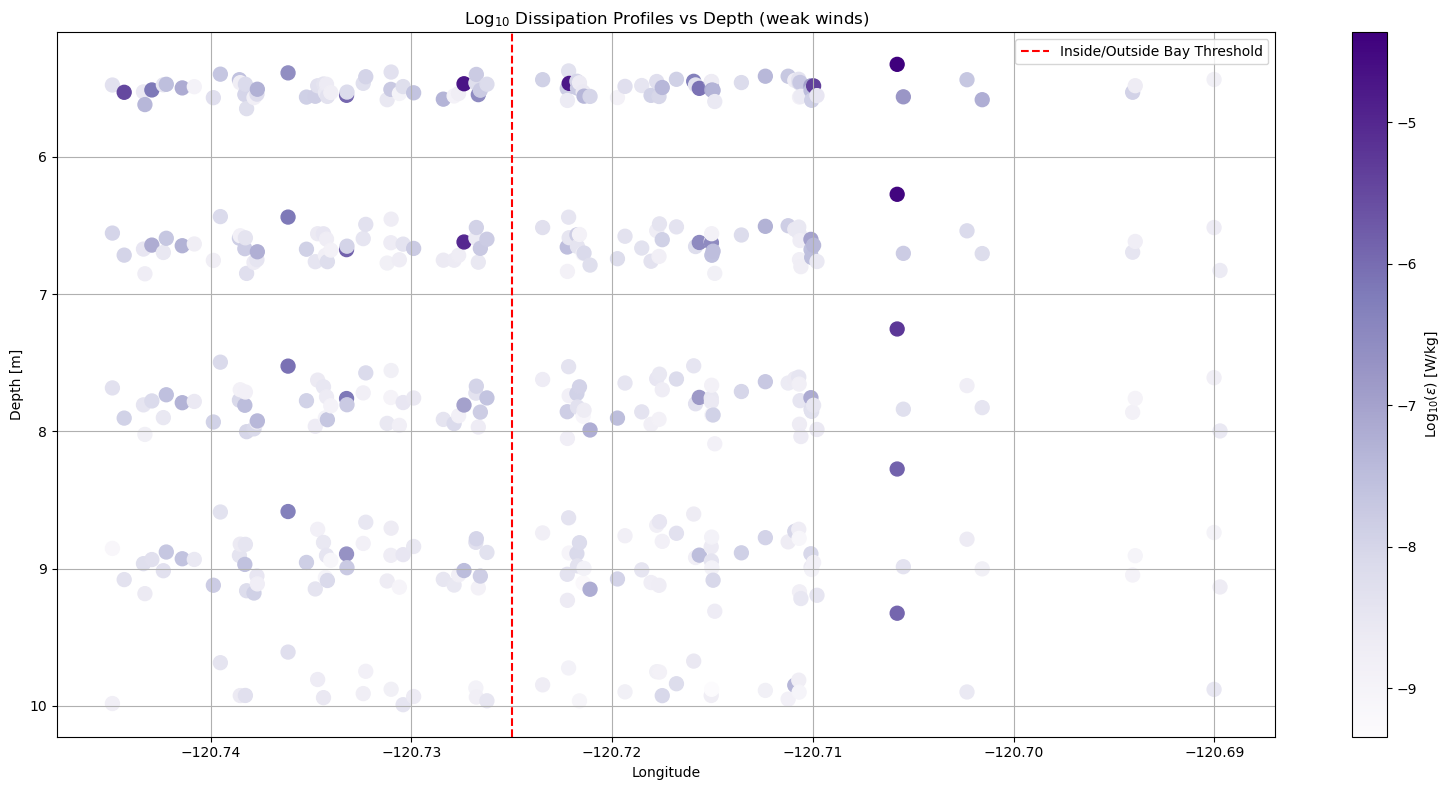

In [127]:
df_weak = pd.concat([df_weak_in, df_weak_out])
df_weak_sorted = df_weak.sort_values('longitude').reset_index(drop=True)

# Flatten profile data into individual points
longitudes = []
depths = []
log_dissipation = []

for i, row in df_weak_sorted.iterrows():
    diss = np.array(row['dissipation'])
    depth = np.array(row['pressure'])
    lon = row['longitude']
    
    # Filter out mismatched or missing values
    if len(diss) != len(depth) or np.isnan(lon):
        continue
    
    log_eps = np.log10(diss)
    
    # Remove nan or inf
    mask = np.isfinite(log_eps) & np.isfinite(depth)
    
    longitudes.extend([lon] * np.sum(mask))
    depths.extend(depth[mask])
    log_dissipation.extend(log_eps[mask])

# Create scatter plot
plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c=log_dissipation, cmap='Purples', s=100)
plt.gca().invert_yaxis() 
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Log$_{10}$ Dissipation Profiles vs Depth (weak winds)')
cbar = plt.colorbar(sc)
cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')
plt.grid(True)
plt.tight_layout()
df_weak_sorted

/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/1497697464.py:33: RuntimeWarning: invalid value encountered in log
  I = np.log(np.array(dissipation))/np.log((np.array(N_squareds)) * np.log(viscosity))


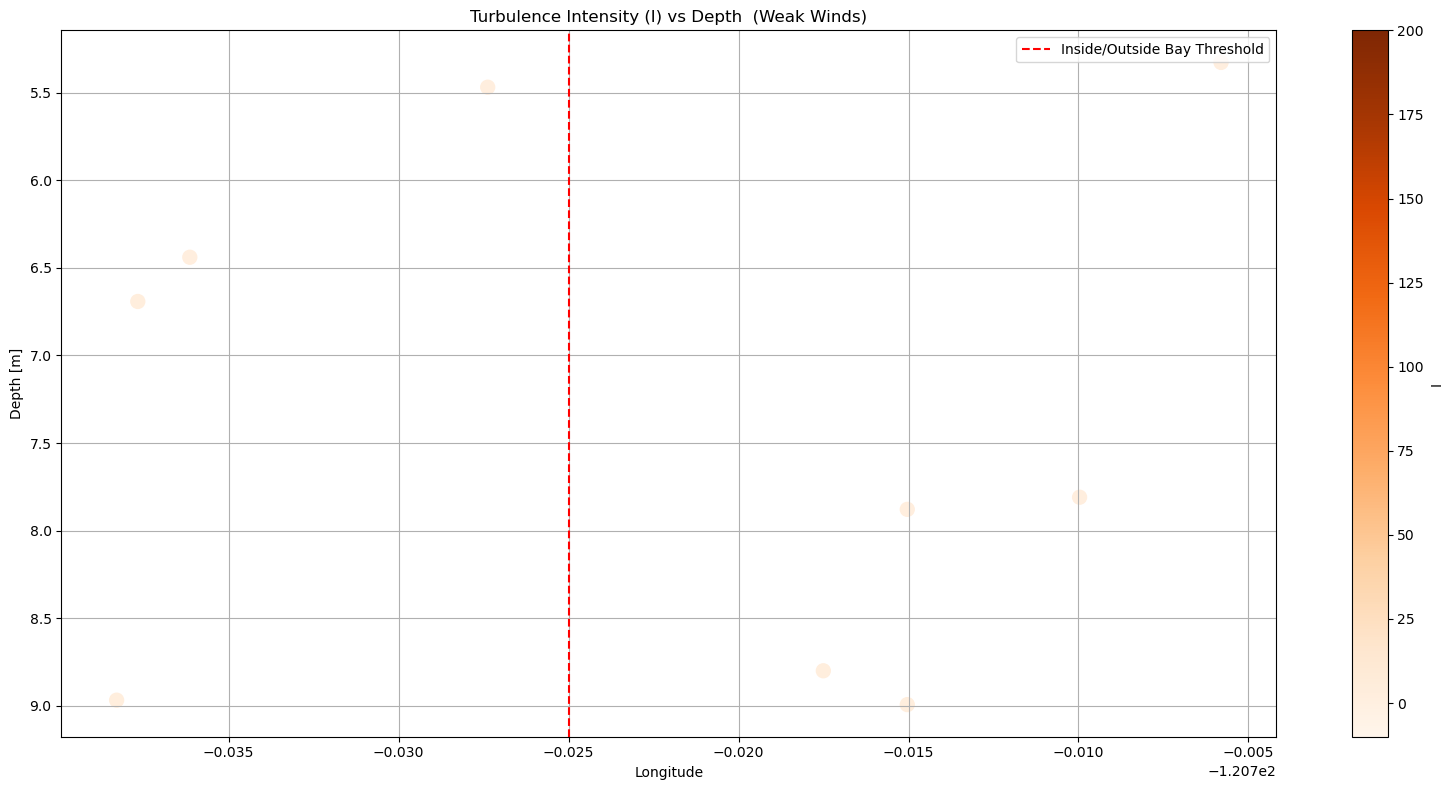

In [112]:
# Combine all data
df_weak = pd.concat([df_weak_in, df_weak_out])
df_weak_sorted = df_weak.sort_values('longitude').reset_index(drop=True)

# Flatten profile data into individual points
longitudes = []
depths = []
log_dissipation = []
N_squareds = []
viscosity = 10**(-6) #m^2/s
dissipation = []

for i, row in df_weak_sorted.iterrows():
    diss = np.array(row['dissipation'])
    depth = np.array(row['pressure'])
    lon = row['longitude']
    N2 = np.array(row['N_squared'])
    # Filter out mismatched or missing values
    if len(diss) != len(depth) or np.isnan(lon):
        continue
    
    log_eps = np.log10(diss)
    
    # Remove nan or inf
    mask = np.isfinite(log_eps) & np.isfinite(depth)
    
    longitudes.extend([lon] * np.sum(mask))
    depths.extend(depth[mask])
    log_dissipation.extend(log_eps[mask])
    N_squareds.extend(N2[mask])
    dissipation.extend(diss[mask])

I = np.log(np.array(dissipation))/np.log((np.array(N_squareds)) * np.log(viscosity))
# Create scatter plot
plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c= I, cmap='Oranges', s=100, vmin=-10, vmax=200 )
plt.gca().invert_yaxis()  
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Turbulence Intensity (I) vs Depth  (Weak Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('I')
plt.grid(True)
plt.tight_layout()

In [116]:
from scipy.stats import linregress
slope, intercept, r_val, p_val, std_err = linregress(np.log(np.array(N_squareds)), np.log(np.array(dissipation)))
print(slope, intercept, r_val, p_val, std_err)

nan nan nan nan nan


/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_8849/156696647.py:2: RuntimeWarning: invalid value encountered in log
  slope, intercept, r_val, p_val, std_err = linregress(np.log(np.array(N_squareds)), np.log(np.array(dissipation)))


In [89]:
from scipy.stats import linregress
slope, intercept, r_val, p_val, std_err = linregress(N_squareds, longitudes)
print(slope, intercept, r_val, p_val, std_err)

0.8269759286247486 -120.72425563692669 0.039656890247214104 0.41647010575877585 1.016735057078004


In [104]:
from scipy.stats import linregress
slope, intercept, r_val, p_val, std_err = linregress(I, np.array(dissipation))
print(slope, intercept, r_val, p_val, std_err)

-1.458094492731248e-11 3.7308756183138323e-07 -0.04612247186341654 0.34457209210768924 1.54094104842656e-11


-0.011415397736756051

0.08344691045590584